In [1]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import graphviz as gr
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import skewnorm 
random.seed(99)
np.random.seed(99)

In [2]:
def generate_x(N, corr, nvar):
    # generate random normal distribution
    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],N),(N,-1)))
    normvars = np.concatenate(acc,axis=1)
    
    #generate covariates
    acc1  = []
    for i in range(nvar):
        row = np.ones((1,nvar)) * corr
        row[0][i] = 1
        acc1.append(row)
    cov = np.concatenate(acc1,axis=0) # covariates
    C = np.linalg.cholesky(cov) # confounder
    
    xi = np.transpose(np.dot(C,np.transpose(normvars))) # all X
    return xi

In [3]:
def performance(tau0, N, result):
    ate = np.mean(result["tauhat"]) 
    b = result["tauhat"] - tau0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2)) 
    t = b/result["sehat"]
    size = np.mean(1*(np.abs(t)>1.96)) 

    print(f'N={N}:') 
    print("treatment effect=", ate)
    print(f'bias={bias}')
    print(f'RMSE={rmse}')
    print(f'size={size}\n')

In [4]:
def MonteCarlo(case, iteration):
    est = {}
    tau = 2
    for N in [100, 1000]:
        tauhats = []
        sehats = [] 
        for i in tqdm(range(iteration), position = 0, leave = True):
            
            # Do not control for covariates
            if case == 11: 
                y, T, X, Ncov = DGP1(N) # data generating
                yt = y[np.where(T==1)[0],:] # y treatment group 
                yc = y[np.where(T==0)[0],:] # y controlled group
                tauhat = np.mean(yt)-np.mean(yc) # ATE
                se_tauhat = (np.var(yt,ddof=1)/len(yt)+np.var(yc,ddof=1)/len(yc))**(1/2) # SE
            else: 
                # Control for all covariates
                if case == 12: 
                    y, T, X, Ncov = DGP1(N) # data generating
                    Xobs = X[:,:Ncov]
                    covars = np.concatenate([T,Xobs],axis = 1)
                    mod = sm.OLS(y,covars)
                    
                # Fail to control for the confounder
                if case == 21: 
                    y, T, T1, C = DGP2(N) # data generating
                    confound = np.concatenate([T1],axis = 1) 
                    mod = sm.OLS(y,confound) 
                    
                # Control for the confounder
                if case == 22: 
                    y, T, T1, C = DGP2(N) # data generating
                    confound = np.concatenate([T1,C],axis = 1)
                    mod = sm.OLS(y,confound)
                
                # Control for the mediator variable
                if case == 31: 
                    y, T, M = DGP3(N) # data generating
                    mediator = np.concatenate([T,M],axis = 1)
                    mod = sm.OLS(y,mediator)
                
                # Do not control for the mediator variable
                if case == 32:
                    y, T, M = DGP3(N) # data generating 
                    mod = sm.OLS(y,T)   
            
                res = mod.fit() 
                tauhat = res.params[0] #tau hat
                se_tauhat = res.HC1_se[0] #se hat
                
            tauhats = tauhats + [tauhat]
            sehats = sehats + [se_tauhat]    

            est[N] = {
                'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
                'sehat':np.array(sehats).reshape([len(sehats),1])
            }
            
    # Estimation, Bias, RMSE, Size
    tau0 = tau*np.ones([iteration,1])
    for N, result in est.items():
        performance(tau0, N, result) 

***

# 1. Randomly assigned treatment and observed covariates

Consider a study on the causal effect of education on earnings. 
* Treatment: education;   Outcome: income
* Age and gender are the observed covariates
* Education level affects income, but age, gender, and other covariates also affect income. By controlling the covariates, we only evaluate the effect of the treatment on outcome, which gives a more precise causal effect estimation.

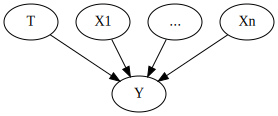

In [5]:
g1 = gr.Digraph()
g1.edge("T", "Y")
g1.edge("X1", "Y")
g1.edge("...", "Y")
g1.edge("Xn", "Y")
g1

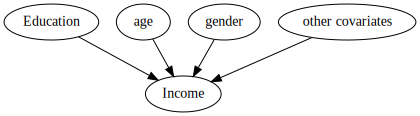

In [6]:
g11 = gr.Digraph()
g11.edge("Education", "Income"), g11.edge("age", "Income"), g11.edge("gender", "Income"),g11.edge("other covariates", "Income")
g11

## DGP1:    

### &emsp;&emsp; $y_i = \tau*T_i+\beta'*x_i+e_i$

<br>

* Treatment effect $\tau$ = 2

* Treatment $T_i$ is randomly sampled from 0 and 1 with 50% probability.

* Explanatory variable $x_i$ is a Nx10 matrix, where 5 of the 10 explanatory variables are the covariates.  

* $x_i$ is randomly generated with a normal distribution.

* Coefficient on covariates $\beta$ is randomly generated with a normal distribution. 

* Correlation for multivariate normal is 0.5

* Error term $e_i$ is randomly generated with a normal distribution (mean = 0)


In [7]:
def DGP1(N): 
    tau = 2 # treatment effect
    corr = 0.5 # correlation for multivariate normal
    Nvar = 10 # number of variables
    Ncov = 5 # number of covariates
    
    err = np.random.normal(0,1,[N,1]) # random error
    T = random.sample(range(N), round(N*0.5)) # random treatment (1 and 0)
    T = np.array([(1 if i in T else 0) for i in range(N)]).reshape([N,1])     

    X = generate_x(N, corr, Nvar) # all X

    beta0 = np.random.normal(5,5,[Nvar,1]) 
    beta0[Ncov:Nvar] = 0 # sparse model
    
    y = tau*T+X@beta0+err 

    return (y, T, X, Ncov)

In [8]:
# export data to csv

# N=100
y, T, X, Ncov = DGP1(100) # data generating
data = pd.DataFrame(dict(y = y[:,0].tolist(),
                         treatment=T[:,0].tolist(),
                         covariate1 = X[:,0].tolist(),
                         covariate2 = X[:,1].tolist(),
                         covariate3 = X[:,2].tolist(),
                         covariate4 = X[:,3].tolist(),
                         covariate5 = X[:,4].tolist()
                    )
               )
data.to_csv("covariates_100.csv", index=False)

#N=1000
y, T, X, Ncov = DGP1(1000) # data generating
data = pd.DataFrame(dict(y = y[:,0].tolist(),
                         treatment=T[:,0].tolist(),
                         covariate1 = X[:,0].tolist(),
                         covariate2 = X[:,1].tolist(),
                         covariate3 = X[:,2].tolist(),
                         covariate4 = X[:,3].tolist(),
                         covariate5 = X[:,4].tolist()
                    )
               )
data.to_csv("covariates_1000.csv", index=False)

## 1a. Do not control for any covariates

* Run Monte Carlo experiments (2000 iterations) with sample sizes N=100 and N=1000

* Treatment effect is calculated simply by ATE

* ATE = E[$y_i$|$T_i$=1] - E[$y_i$|$T_i$=0]

In [9]:
# Run Monte Carlo experiments
case = 11
iteration = 2000
MonteCarlo(case, iteration)

100%|██████████| 2000/2000 [00:12<00:00, 165.13it/s]

N=100:
treatment effect= 2.012604193702416
bias=0.012604193702415842
RMSE=4.687504587371756
size=0.0555

N=1000:
treatment effect= 2.037314764708931
bias=0.03731476470893151
RMSE=1.396266806166737
size=0.0525



## 1b. Control for all covariates


* Using the same generated data in 1a. 

* Run Monte Carlo experiments (2000 iterations) with sample sizes N=100 and N=1000

* Covariates are controlled using OLS.

In [10]:
# Run Monte Carlo experiments
case = 12
iteration = 2000
MonteCarlo(case, iteration)

100%|██████████| 2000/2000 [00:39<00:00, 50.46it/s]

N=100:
treatment effect= 1.9981316447761441
bias=-0.0018683552238559769
RMSE=0.14816522874736748
size=0.0675

N=1000:
treatment effect= 2.0014636515086766
bias=0.0014636515086767297
RMSE=0.04493890026633254
size=0.051



***

# 2.  Confounding

Again, consider a study on the causal effect of education on earnings.

* Treatment: Education; Outcome: Income

* Confounder: IQ

* Intelligence level is the common cause of both income and education. It is plausible to say that smarter people are more likely to pursue a high level of education. However, if a person is smarter, he/she is likely to get a higher income by nature, regardless of the education level. Therefore, in order to get a sufficient result, we need to control IQ and compare people with the same intelligence level. 

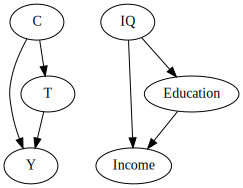

In [11]:
g2 = gr.Digraph()
g2.edge("C", "Y"), g2.edge("C", "T"), g2.edge("T", "Y")
g2.edge("IQ", "Income"), g2.edge("IQ", "Education"), g2.edge("Education", "Income")

g2

## DGP2: 

### &emsp;&emsp; $y_i = \tau*T1_i+\beta*C_i +e_i$  

### &emsp;&emsp; $T1_i = T_i+\alpha*C_i$

<br>

* Treatment effect $\tau$ = 2

* Treatment $T_i$ is randomly sampled from 0 and 1 with 50% probability.

* $T1_i$ represents the treatment that is correlated to the confounder.

* $\alpha$, the correlation between the confounder and the treatment, is randomly generated with a normal distribution at mean=0.5

* Confounder $C_i$ is randomly generated with a normal distribution.

* Coefficient on the confounder $\beta$ is randomly sampled between 0.5 to 1 with a uniform distribution. 

* Error term $e_i$ is randomly generated with a normal distribution (mean = 0)


In [12]:
def DGP2(N):  
    tau = 2
    corr = .5 
    
    err = np.random.normal(0,1,[N,1]) # random error
    T = random.sample(range(N), round(N*0.5)) # random treatment (1 and 0)
    T = np.array([(1 if i in T else 0) for i in range(N)]).reshape([N,1])     
    
    beta= np.random.uniform(0.5, 1) 
    C = generate_x(N, corr, 1).reshape([N,1]) # confounder
    a = np.random.normal(0.5,1) # correlation between C and T
    T1 = T+a*C  # treatment is correlated with confounder
    y = tau*T1+beta*C+err
    
    return (y, T, T1, C)

In [13]:
# export data to csv

y, T, T1, C = DGP2(100)
data = pd.DataFrame(dict(y = y[:,0].tolist(),
                         treatment=T[:,0].tolist(),
                         treatment_confounding=T1[:,0].tolist(),
                         confounder=C[:,0].tolist(),
                    )
               )

data.to_csv("confounder_100.csv", index=False)

y, T, T1, C = DGP2(1000) # data generating
data = pd.DataFrame(dict(y = y[:,0].tolist(),
                         treatment=T[:,0].tolist(),
                         treatment_confounding=T1[:,0].tolist(),
                         confounder=C[:,0].tolist()
                    )
               )

data.to_csv("confounder_1000.csv", index=False)

## 2a. Fail to control for the confounder

* Run Monte Carlo experiments with sample sizes N=100 and N=1000

* Treatment effect is evaluated without controlling the confounder

In [14]:
# Run Monte Carlo experiments
case = 21
iteration = 2000
MonteCarlo(case, iteration)

100%|██████████| 2000/2000 [00:16<00:00, 119.70it/s]

N=100:
treatment effect= 2.151916665868605
bias=0.15191666586860497
RMSE=0.43643280836740284
size=0.778

N=1000:
treatment effect= 2.146559611891843
bias=0.14655961189184258
RMSE=0.4234830072546549
size=0.9155



## 2b. Control for the confounder

* Run Monte Carlo experiments with sample sizes N=100 and N=1000

* Treatment effect is evaluated using ols with treatment and the confounder

In [15]:
# Run Monte Carlo experiments
case = 22
iteration = 2000
MonteCarlo(case, iteration)

100%|██████████| 2000/2000 [00:20<00:00, 98.97it/s] 

N=100:
treatment effect= 2.006101242091494
bias=0.006101242091494095
RMSE=0.14129031315371995
size=0.0555

N=1000:
treatment effect= 1.9989023978948317
bias=-0.001097602105168301
RMSE=0.04432205336367938
size=0.051



***

# 3.  Selection Bias

Consider the same example of education and earnings.

* Treatment: Education; Outcome: Income

* Selection Bias: Motivation

* Motivation is the mediator in between the path from the education to the earnings. People with high level of education are likely to be more motivated to work. At the same time, more motivated person may have higher income. In this case, we should not control the motivation level because it is one way that the education is affecting earnings. 

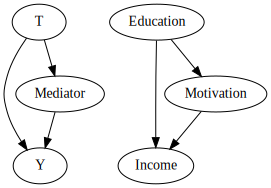

In [16]:
g2 = gr.Digraph()
g2.edge("T", "Y"), g2.edge("T", "Mediator"), g2.edge("Mediator", "Y")
g2.edge("Education", "Income"), g2.edge("Education", "Motivation"), g2.edge("Motivation", "Income")

g2

## DGP3: 

### &emsp;&emsp; $y_i = \frac{\tau}{\alpha+1}*T_i+\frac{\tau}{\alpha+1}*M_i +e_i$  &emsp;&emsp;&emsp; $M_i =  \alpha*T_i$

### &emsp;&emsp; $y_i = \frac{\tau}{\alpha+1}*T_i+\frac{\tau}{\alpha+1}*\alpha*T_i +e_i$

### &emsp;&emsp; $y_i = \tau*T_i+e_i$


<br>

* Treatment effect $\tau$ = 2

* Treatment $T_i$ is randomly sampled from 0 and 1 with 50% probability.

* Mediator $M_i$ is correlated to the treatment $T_i$ by $\alpha$

* The correlation between the mediator and the treatment $\alpha$ is randomly sampled between 0.2 to 1 with a uniform distribution. 

* Error term $e_i$ is randomly generated with a normal distribution (mean = 0)


In [17]:
def DGP3(N):  
    tau = 2
    err = np.random.normal(0,0.2,[N,1]) # random error
    T = random.sample(range(N), round(N*0.5)) # random treatment (1 and 0)
    T = np.array([(1 if i in T else 0) for i in range(N)]).reshape([N,1])     
    
    a = np.random.uniform(0.2, 1, size=[N,1])
    M = a*T+np.random.normal(0, 0.2, [N,1])  # mediator is correlated with treatment
    y = tau/(a+1)*T+tau/(a+1)*M + err
        
    return (y, T, M)

In [18]:
y, T, M = DGP3(100) # data generating
data = pd.DataFrame(dict(y = y[:,0].tolist(),
                         treatment=T[:,0].tolist(),
                         mediator=M[:,0].tolist()
                    )
               )

data.to_csv("SelectionBias_100.csv", index=False)

y, T, M = DGP3(1000) # data generating
data = pd.DataFrame(dict(y = y[:,0].tolist(),
                         treatment=T[:,0].tolist(),
                         mediator=M[:,0].tolist()
                    )
               )

data.to_csv("SelectionBias_1000.csv", index=False)

## 3a. Control for the mediator variable

* Run Monte Carlo experiments with sample sizes N=100 and N=1000

* Treatment effect is evaluated on both treatment and the mediator

In [19]:
# Run Monte Carlo experiments
case = 31
iteration = 2000
MonteCarlo(case, iteration)

100%|██████████| 2000/2000 [00:20<00:00, 98.76it/s] 

N=100:
treatment effect= 1.5405776976093208
bias=-0.4594223023906791
RMSE=0.4647332690639451
size=1.0

N=1000:
treatment effect= 1.5402144788653431
bias=-0.4597855211346568
RMSE=0.46033292721888347
size=1.0



## 3b. Do not control for the mediator variable

* Run Monte Carlo experiments with sample sizes N=100 and N=1000

* Treatment effect is evaluated soley with the treatment

In [20]:
# Run Monte Carlo experiments
case = 32
iteration = 2000
MonteCarlo(case, iteration)

100%|██████████| 2000/2000 [00:18<00:00, 110.10it/s]

N=100:
treatment effect= 1.9990701928135255
bias=-0.0009298071864745898
RMSE=0.04703856424883858
size=0.059

N=1000:
treatment effect= 1.9998056029482605
bias=-0.0001943970517393192
RMSE=0.014871311362562104
size=0.0555

